# Imports

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from datasets import load_dataset
import matplotlib.pyplot as plt

import torch.nn as nn
import pandas as pd
import os

from tokenization.word_tokenizer import WordTokenizer
from trainer.trainer import Trainer
from model.bilstm import BiLSTM
from model.cbilstm import CBiLSTM

/home/nico/miniconda3/envs/nlp-tools/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
MAX_VOCAB_SIZE  = 20_000
MAX_LEN         = 256
SEED            = 42
EPOCHS          = 5
BATCH_SIZE      = 128
LEARNING_RATE   = 1e-4

# Load Data and preprocess data

In [8]:
train_data = load_dataset('imdb', split="train[10:85%]")
eval_data = load_dataset('imdb', split="train[:10%]+train[85%:]")
test_data = load_dataset('imdb', split="test")

In [9]:
tokenizer = WordTokenizer(train_data['text'], MAX_VOCAB_SIZE, MAX_LEN)

# Train

In [11]:
lr = 1e-4
ed = 300
rs = 256
hs = 256
do = 0.5

In [9]:
model = BiLSTM(
    vocab_size      = MAX_VOCAB_SIZE,
    embedding_dim   = ed,
    rnn_size        = rs,
    hidden_size     = hs,
    dropout         = do,
    padding_index   = tokenizer.get_pad_token()
)

criterion = nn.BCELoss()
trainer = Trainer(
    model,
    tokenizer,
    criterion,
    train_data,
    eval_data,
    num_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    run_name='pytorch_model',
    early_stop=False,
    learning_rate=lr
)

trainer.train()

Validation: 100%|██████████| 6250/6250 [01:00<00:00, 102.77it/s]


In [12]:
cmodel = CBiLSTM(
    vocab_size      = MAX_VOCAB_SIZE,
    embedding_dim   = ed,
    rnn_size        = rs,
    hidden_size     = hs,
    dropout         = do,
    padding_index   = tokenizer.get_pad_token()
)

criterion = nn.BCELoss()
trainer = Trainer(
    cmodel,
    tokenizer,
    criterion,
    train_data,
    eval_data,
    num_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    run_name='custom_model',
    early_stop=False,
    learning_rate=lr
)

trainer.train()

Validation: 100%|██████████| 6250/6250 [00:56<00:00, 110.94it/s]


# Test and Plot Results

In [13]:
def draw_axes(ax, data, title, metric_columns, labels, y_label=None):
    ax.set_title(title)

    ax.plot(data['epoch'], data[metric_columns[0]], label=labels[0])
    ax.plot(data['epoch'], data[metric_columns[1]], label=labels[1], linestyle='dashed')

    ax.set_xlabel('Epoch')
    if y_label is not None:
        ax.set_ylabel(y_label)
    else:
        ax.set_ylabel(title)
    ax.legend()
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y')

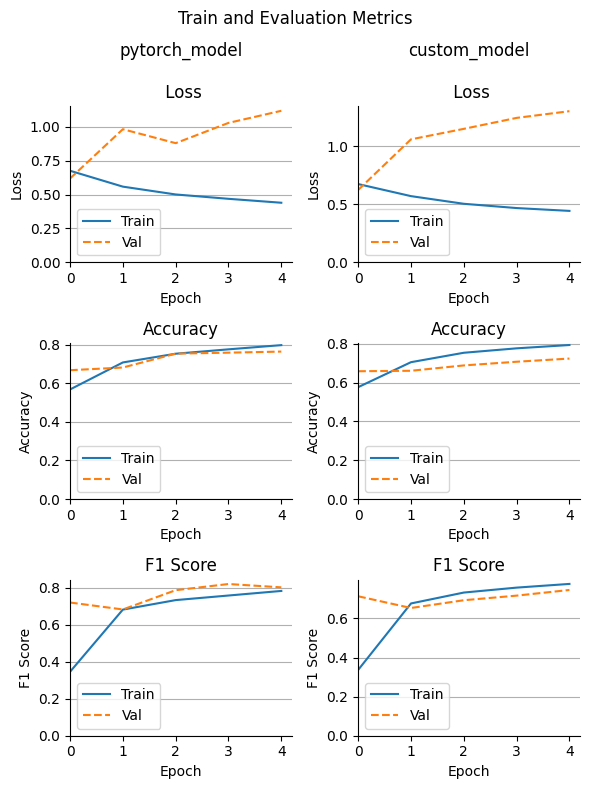

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(6, 8))

fig.suptitle(f'Train and Evaluation Metrics')

for idx, directory in enumerate(os.listdir('out/')):
    metrics = pd.read_csv(f'out/{directory}/metrics/metrics.csv')

    axes[0][idx].set_title(directory)

    draw_axes(axes[0][idx], metrics, f'{directory}\n\n Loss', ['train_loss', 'val_loss'], ['Train', 'Val'], 'Loss')
    draw_axes(axes[1][idx], metrics, 'Accuracy', ['train_accuracy', 'val_accuracy'], ['Train', 'Val'])
    draw_axes(axes[2][idx], metrics, 'F1 Score', ['train_f1', 'val_f1'], ['Train', 'Val'])

    plt.tight_layout()